<a href="https://colab.research.google.com/github/RamSaw/deep-unsupervised-learning/blob/HW_02_T_01/HW_02_T_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import random
import os
import matplotlib.pyplot as plt
import matplotlib
import torch 
import torch.nn as nn
from torch.distributions import Normal
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

In [2]:
def make_reproducible(seed, make_cuda_reproducible):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if make_cuda_reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 2341
make_reproducible(SEED, False)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


Data info for all dataset
(99999, 2)
(99999,)
[-1.91759247 -0.12925264]
2


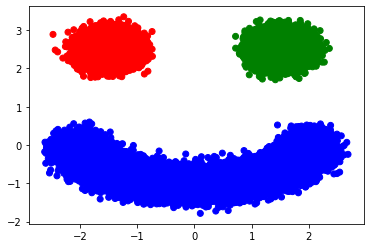

In [3]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

def print_data_info(X, y, label):
    print(f'Data info for {label}')
    print(X.shape)
    print(y.shape)
    print(X[1])
    print(y[1])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(['red','green','blue']))
    plt.show()
  
X, Y = sample_data()
print_data_info(X, Y, 'all dataset')

Data info for train
torch.Size([79999, 2])
torch.Size([79999])
tensor([-1.8588, -0.3814])
tensor(2.)


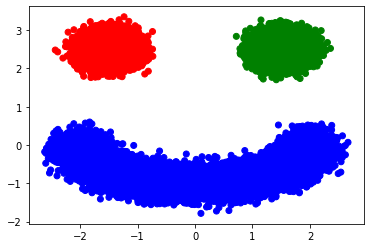

Data info for test
torch.Size([20000, 2])
torch.Size([20000])
tensor([ 1.5242, -0.3453])
tensor(2.)


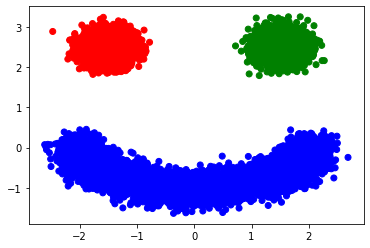

In [4]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, test_size=0.2, random_state=SEED)
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = torch.FloatTensor(X_TRAIN), torch.FloatTensor(X_TEST), torch.FloatTensor(Y_TRAIN), torch.FloatTensor(Y_TEST)
print_data_info(X_TRAIN, Y_TRAIN, 'train')
print_data_info(X_TEST, Y_TEST, 'test')

In [5]:
X_Y_TRAIN = torch.cat((X_TRAIN, Y_TRAIN.unsqueeze(1)), dim=1)
X_Y_TEST = torch.cat((X_TEST, Y_TEST.unsqueeze(1)), dim=1)
print(X_Y_TRAIN.shape)
print(X_Y_TEST.shape)

torch.Size([79999, 3])
torch.Size([20000, 3])


In [0]:
class FlowModel(nn.Module):
    def __init__(self, k):
    
      super(FlowModel, self).__init__()
      self.k = k
      self.batch = 0
      self.pi1_layer = nn.Parameter(torch.randn(self.k, requires_grad=True))
      self.pi1_softmax = nn.Softmax(dim=-1)
      self.mu1_layer = nn.Parameter(torch.randn(self.k, requires_grad=True))
      self.sigma1_layer = nn.Parameter(torch.randn(self.k, requires_grad=True))

      # Flow for x2
      self.x_to_hidden = nn.Sequential(
          nn.Linear(1, 100),
          nn.Tanh()
      )
      self.pi2_layer = nn.Sequential(
          nn.Linear(100, self.k),
          nn.Softmax(dim=-1)
      )
      self.mu2_layer = nn.Linear(100, self.k)
      self.sigma2_layer = nn.Linear(100, self.k)

    def get_x2_dist_params(self,x):
        hidden = self.x_to_hidden(x)
        pi = self.pi2_layer(hidden)
        mu = self.mu2_layer(hidden)
        sigma = torch.abs(self.sigma2_layer(hidden))
        
        return pi, mu, sigma
    
    def get_dist_params(self, x):
      x1, x2 = x[:, :1],x[:, 1:]
      self.batch = x1.shape[0]

      pi1 = self.pi1_softmax(self.pi1_layer.repeat(self.batch, 1))
      mu1 = self.mu1_layer.repeat(self.batch, 1)
      sigma1 = torch.abs(self.sigma1_layer.repeat(self.batch, 1))
      pi2, mu2, sigma2 = self.get_x2_dist_params(x1)
      
      return (pi1, mu1, sigma1, pi2, mu2, sigma2)
    
    def f(self,x):
      """
      Integral from -inf to x = cdf(x)
      """
      pi1, mu1, sigma1, pi2, mu2, sigma2 = self.get_dist_params(x)
      
      z1 = torch.zeros(self.batch,1)
      z2 = torch.zeros(self.batch,1)
      
      x1, x2 = x[:, :1],x[:, 1:]
      self.batch = x1.shape[0]
      
      for i in range(self.k):
        z1 += pi1[:,i:i+1] * (Normal(mu1[:,i:i+1].float(),(sigma1[:,i:i+1]).float()).cdf(x1))
        z2 += pi2[:,i:i+1] * (Normal(mu2[:,i:i+1].float(),(sigma2[:,i:i+1]).float()).cdf(x2))
      return z1, z2
    
    def probs(self,x):
      """
      log p(x) = log p(f(x)) + log det (df/dx)
      log p(f(x)) = 0 since f(x) is uniformly distributed and log p(f(x)) = log 1 = 0
      df(x1) / dx2 = 0 => log det (df / dx) = g(x1) + g(x2),
      where g(x) = pi * d (integral^x_{-inf}(p_normal)) / dx = pi * p_normal(x)
      """
      pi1, mu1, sigma1, pi2, mu2, sigma2 = self.get_dist_params(x)      
      
      prob_x1 = torch.zeros(self.batch, 1)
      prob_x2 = torch.zeros(self.batch, 1)
      
      x1, x2 = x[:, :1],x[:, 1:]
      self.batch = x1.shape[0]
      
      for i in range(self.k):
        prob_x1 += pi1[:,i:i+1] * (Normal(mu1[:,i:i+1].float(), (sigma1[:,i:i+1]).float()).log_prob(x1).exp())
        prob_x2 += pi2[:,i:i+1] * (Normal(mu2[:,i:i+1].float(), (sigma2[:,i:i+1]).float()).log_prob(x2).exp())
        
      return prob_x1 * prob_x2
    
    def loss(self,x):
      return torch.mean(-torch.log(self.probs(x)) / np.log(2)) / 2

In [0]:
def train(model, train_batch_size, test_batch_size, epochs_cnt):
    train_iter = torch.utils.data.DataLoader(X_Y_TRAIN, batch_size=train_batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(X_Y_TEST, batch_size=test_batch_size, shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

    losses, val_losses = [], []
    for epoch in range(epochs_cnt):
        loss = 0
        tmp_losses = []
        
        model.train()
        total_train_loss = 0
        for item in train_iter:
            X_batch, y_batch = item[:, :2], item[:, 2]
            loss = model.loss(X_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            tmp_losses.append(loss.detach().numpy())
        losses.append(np.mean(tmp_losses))
        
        model.eval()
        with torch.no_grad():
            tmp_val_losses = []
            for item in val_iter:
                X_batch, y_batch = item[:, :2], item[:, 2]
                val_loss = model.loss(X_batch)
                tmp_val_losses.append(val_loss.detach().numpy())
            val_losses.append(np.mean(tmp_val_losses))
        if epoch % 1 ==0:
            print('Epoch {}: loss {} val_loss {} '.format(epoch,np.mean(tmp_losses),np.mean(tmp_val_losses)))
    return losses, val_losses    

In [0]:
def plot_losses(losses, val_losses):
  plt.plot(losses, label = "train_loss")
  plt.plot(val_losses, label = "val_loss")
  plt.legend()
  plt.show()

In [0]:
K = 6
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
EPOCHS_CNT = 25

Epoch 0: loss 2.2100367546081543 val_loss 1.425491213798523 
Epoch 1: loss 1.283370018005371 val_loss 1.1731318235397339 
Epoch 2: loss 1.0748897790908813 val_loss 1.034179925918579 
Epoch 3: loss 1.0138088464736938 val_loss 1.0052827596664429 
Epoch 4: loss 0.99542635679245 val_loss 1.000327467918396 
Epoch 5: loss 0.9838581681251526 val_loss 0.9833764433860779 
Epoch 6: loss 0.9825215935707092 val_loss 0.9843370318412781 
Epoch 7: loss 0.9795779585838318 val_loss 0.998038113117218 
Epoch 8: loss 0.978256106376648 val_loss 0.982094407081604 
Epoch 9: loss 0.9787840247154236 val_loss 0.9911702871322632 
Epoch 10: loss 0.9766942262649536 val_loss 0.9812465906143188 
Epoch 11: loss 0.9774671196937561 val_loss 0.9864280819892883 
Epoch 12: loss 0.97724449634552 val_loss 0.9883530735969543 
Epoch 13: loss 0.977143406867981 val_loss 0.9899811744689941 
Epoch 14: loss 0.9782842397689819 val_loss 0.98725426197052 
Epoch 15: loss 0.9786901473999023 val_loss 0.9851767420768738 
Epoch 16: loss 0

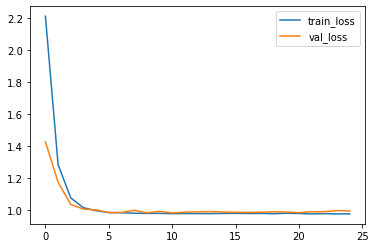

In [10]:
model = FlowModel(K)
TRAIN_LOSSES, VAL_LOSSES = train(model, TRAIN_BATCH_SIZE, TEST_BATCH_SIZE, EPOCHS_CNT)
plot_losses(TRAIN_LOSSES, VAL_LOSSES)

torch.Size([80, 80])


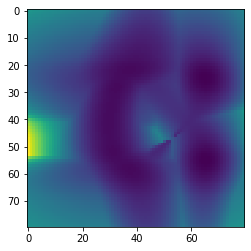

In [11]:
def draw_dist(model):
    space = np.arange(-4, 4, 0.1)
    grid = torch.zeros((len(space) ** 2, 2))
    probs = torch.zeros(len(space), len(space))
    ind = 0
    for i in range(len(space)):
        for j in range(len(space)):
            x1 = space[i]
            x2 = space[j]
            loss = model.loss(torch.FloatTensor([[x1, x2]]))
            probs[i][j] = loss.data.item()
    print(probs.shape)
    plt.imshow(probs)
    plt.show
draw_dist(model)

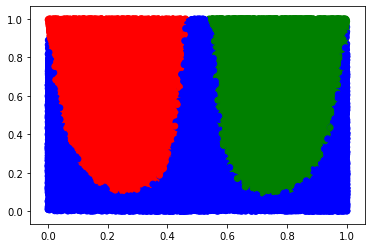

In [12]:
def draw_latent_space(model):
    z1, z2 = model.f(X_TRAIN)
    plt.scatter(z1[:, 0].detach().numpy(), z2[:, 0].detach().numpy(), c=Y_TRAIN, cmap=matplotlib.colors.ListedColormap(['red','green','blue']))
    plt.show()

draw_latent_space(model)

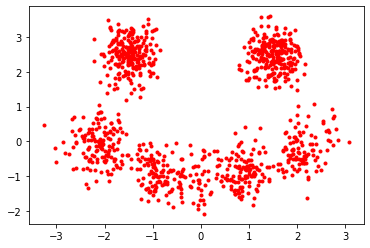

In [13]:
def sample_preds(pi, sigmasq, mu, samples):
  N, K = pi.shape
  out = Variable(torch.zeros(N, samples, 1))
  for i in range(N):
    for j in range(samples):
      u = np.random.uniform()
      prob_sum = 0
      for k in range(K):
        prob_sum += pi.data[i, k]
        if u < prob_sum:
          sample = np.random.normal(mu.data[i, k], np.sqrt(sigmasq.data[i, k]))
          out[i, j, 0] = sample
          break
  return out

def display_samples(model):
    pi1 = model.pi1_softmax(model.pi1_layer.view(1,-1))
    mu1 = model.mu1_layer.view(1,-1)
    sigma1 = torch.abs(model.sigma1_layer).view(1,-1)
    preds_x1 = sample_preds(pi1, sigma1, mu1, samples=1000)
    pi2, mu2, sigma2 = model.get_x2_dist_params(preds_x1)
    preds_x2 = sample_preds(pi2[0], sigma2[0], mu2[0], samples=1)
    for i in range(preds_x2.shape[0]):
      plt.plot(preds_x1.squeeze(0).numpy()[i], preds_x2.squeeze(1).numpy()[i], 'r.')
    plt.show()

display_samples(model)

In [14]:
torch.pow(torch.FloatTensor([[2.1, 2], [0, 4]]), 2)

tensor([[ 4.4100,  4.0000],
        [ 0.0000, 16.0000]])